In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from matplotlib.lines import Line2D 

In [2]:
#### DEFINI A TOPOLOGIA DA REDE E VARIÁVEIS INICIAIS
def set_up_configuration(n_cells=400, k_neighbors=4, p_rewire=0.1,normalize=(0,0.25), distribution_type='random'):
    """
    Configura um grafo de Pequeno Mundo (Watts-Strogatz) com atributos de nós.
    Baseado no artigo, mas a estrutura é um grafo, não uma grade.
    k_neighbors: Número de vizinhos iniciais no anel. Valor par.
    p_rewire: Probabilidade de religação de arestas (criação de atalhos).
    """
    # Cria o grafo de pequeno mundo
    G = nx.watts_strogatz_graph(n=n_cells, k=k_neighbors, p=p_rewire, seed=32)

    # Parametros para taxas individuais (heterogeneidade)
    # Lógica de normalização mantida do código original
    minN, maxN = normalize
    if maxN == 1 and minN == 0:
        raw_q = np.random.uniform(minN,maxN,n_cells)    
        raw_r = np.random.uniform(minN,1 - raw_q,n_cells)
    else:
        raw_q = np.random.uniform(minN, maxN, n_cells)
        raw_r = np.random.uniform(0, np.minimum(1, 1 - raw_q), n_cells)

    # Atribui os atributos a cada nó do grafo
    for i in G.nodes():
        G.nodes[i]['status'] = 0  # Inicia todos como Susceptibles (S)
        G.nodes[i]['learningCapability'] = np.abs(np.random.normal(loc=0.0, scale=1.0))
        G.nodes[i]['transferCapability'] = np.abs(np.random.normal(loc=0.0, scale=1.0))
        G.nodes[i]['forgettingRate'] = raw_r[i]
        G.nodes[i]['quittingRate'] = raw_q[i]
        G.nodes[i]['timesContactor'] = 0

    # Define os Disseminadores iniciais (5% do total)
    disseminators = n_cells * 5 // 100
    
    if distribution_type == 'random':
        disseminator_nodes = np.random.choice(G.nodes(), disseminators, replace=False)
        for node_id in disseminator_nodes:
            G.nodes[node_id]['status'] = 2 # Estado I
            
    elif distribution_type == 'monopolistic':
        # Seleciona um nó central e seus vizinhos como disseminadores
        center_node = 300 #n_cells // 2 
        nodes_to_set = list(nx.ego_graph(G, center_node, radius=4).nodes())[:disseminators]
        for node_id in nodes_to_set:
            G.nodes[node_id]['status'] = 2

    elif distribution_type == 'small-group':
        # Cria pequenos clusters de disseminadores em locais distintos
        num_groups = 4
        start_nodes = np.random.choice(G.nodes(), num_groups, replace=False)        
        for start_node in start_nodes:
            nodes_to_set = list(nx.ego_graph(G, start_node, radius=2).nodes())[:5]
            for node_id in nodes_to_set:  
                G.nodes[node_id]['status'] = 2 

    return G

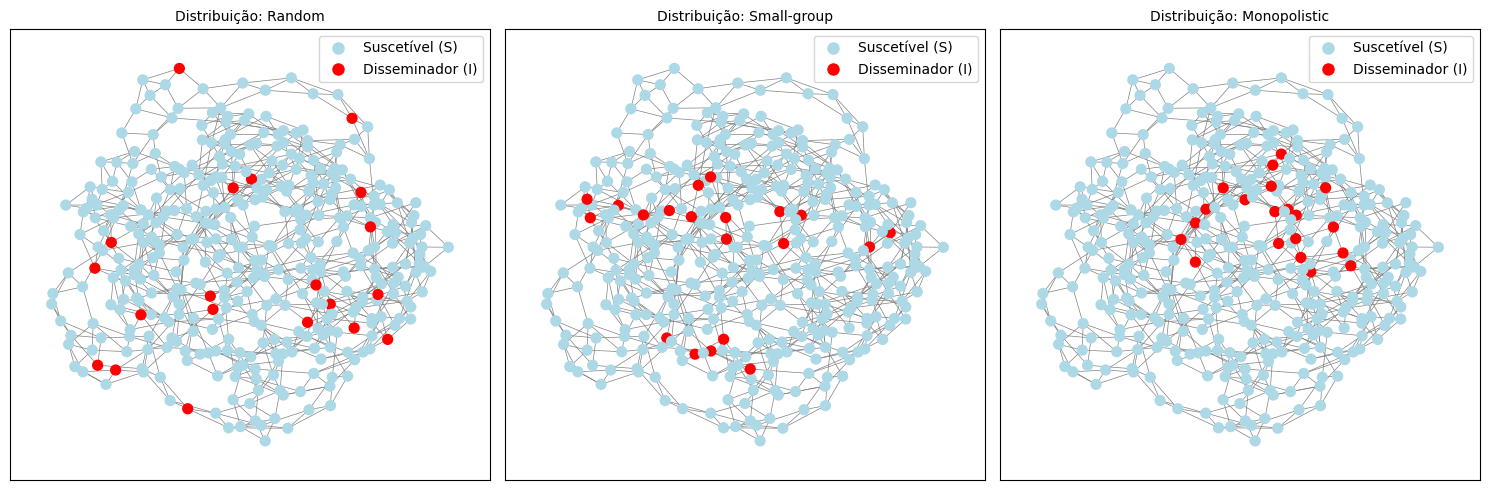

In [3]:
## Visualizar as configurações iniciais
def plot_initial_graph():
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    status_color_map = {
        0: 'lightblue',  # Suscetível (S) 
        1: 'yellow',     # Contatante (E) 
        2: 'red',        # Disseminador (I) 
        3: 'lightgreen', # Esquecedor (R) 
        4: 'gray'        # Desistente (Q) 
    }

    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='Suscetível (S)', markersize=10, markerfacecolor='lightblue'),
        Line2D([0], [0], marker='o', color='w', label='Disseminador (I)', markersize=10, markerfacecolor='red')
    ]

    distribution_type = ['random', 'small-group', 'monopolistic']
    for i, typeG in enumerate(distribution_type):
        G = set_up_configuration(distribution_type=typeG)
        pos = nx.kamada_kawai_layout(G)
        node_colors = [status_color_map.get(G.nodes[n]['status'], 'black') for n in G.nodes()]   

        nx.draw_networkx(
            G,
            pos=pos,
            ax=axes[i],  # Desenhar no eixo correto
            with_labels=False,
            node_size=50,
            node_color=node_colors,
            width=0.5,
            edge_color='gray'
        )
        axes[i].set_title(f'Distribuição: {typeG.capitalize()}', fontsize=10)
        axes[i].legend(handles=legend_elements, loc='upper right')
        axes[i].set_xticks([])
        axes[i].set_yticks([])

    plt.tight_layout()
    plt.show()

plot_initial_graph()

In [4]:
def acquisition_rate(G, node_id):
    """
    Calcula a taxa de aquisição de conhecimento para um nó.
    A interação ocorre com os vizinhos diretos no grafo.
    A distância é implícita (1 para vizinhos diretos)
    """
    # Capacidade de aprendizado do nó atual (S ou R)
    lc_current = G.nodes[node_id]['learningCapability']
    
    max_tax = 0
    # Itera sobre os vizinhos diretos do nó no grafo
    for indices in G.neighbors(node_id):
        if G.nodes[indices]['status'] == 2:  # Se o vizinho é um Disseminador (I)
            tc_vizinho = G.nodes[indices]['transferCapability']
            
            # Fórmula de aquisição adaptada do artigo (sem o termo de distância)
            tax = lc_current * tc_vizinho 
            
            if tax > max_tax:
                max_tax = tax
                
    return max_tax

In [5]:
def apply_transition_S_to_E(G):  ## função para teste
    transicoes = 0

    for i in G.nodes():
        if G.nodes[i]['status'] == 0:
            taxa = acquisition_rate(G, i)
            if taxa > np.random.random() :
                transicoes += 1
                
    print(f'Total de transições S → E realizadas: {transicoes}')

G = set_up_configuration() 
apply_transition_S_to_E(G)

Total de transições S → E realizadas: 29


In [6]:
def transition_F(G):
    """
    Aplica as regras de transição de estado para cada nó no grafo.
    Esta lógica é praticamente idêntica à do modelo AC, pois é baseada nos atributos do nó.
    """
    # Cria um dicionário para armazenar as mudanças de estado do próximo passo
    next_states = {}
    
    for node_id in G.nodes():
        status = G.nodes[node_id]['status']
        D = G.nodes[node_id]['timesContactor']
        
        # Transição de Susceptível (S) para Contatante (E)
        if status == 0:
            taxa = acquisition_rate(G, node_id)
            if taxa > np.random.random():
                next_states[node_id] = {'status': 1, 'timesContactor': D + 1}

        # Transição de Contatante (E) para I, R ou Q
        elif status == 1:
            txR_base = G.nodes[node_id]['forgettingRate']
            txQ_base = G.nodes[node_id]['quittingRate']
            
            # Reforço de aprendizado
            Rl = txR_base ** (D + 1)
            Ql = txQ_base ** (D + 1)
            Il = 1 - Rl - Ql

            if Il < 0: 
                Il = 0
                total = Rl + Ql
                if total > 0:
                    Rl /= total
                    Ql /= total

            r = np.random.rand()
            if r < Ql:
                next_states[node_id] = {'status': 4}  # Q - Desistente
            elif r < Ql + Rl:
                lc_current = G.nodes[node_id]['learningCapability']
                new_lc = lc_current ** (1.0 / (D + 1.0)) if D >= 0 and lc_current > 0 else lc_current
                next_states[node_id] = {'status': 3, 'learningCapability': new_lc} # R - Esquecedor
            else:
                next_states[node_id] = {'status': 2}  # I - Disseminador

        # Transição de Esquecedor (R) para Contatante (E)
        elif status == 3:
            taxa = acquisition_rate(G, node_id)
            if taxa > np.random.random():
                 next_states[node_id] = {'status': 1} # Volta a ser Contatante
    
    # Aplica as mudanças de estado ao grafo
    for node_id, updates in next_states.items():
        for attr, value in updates.items():
            G.nodes[node_id][attr] = value
            
    return G

In [7]:
def simular_difusao(G_initial, max_iter=50):
    """
    Executa a simulação de difusão de conhecimento no grafo.
    A função de mobilidade foi removida, pois os "atalhos" da SWN cumprem nativamente o papel da "mobilidade". *****VALIDAR*****
    """
    G = G_initial.copy()
    history_stats = []

    for passo in range(1, max_iter + 1):
        G = transition_F(G)
        
        # Coleta estatísticas
        all_statuses = [data['status'] for node, data in G.nodes(data=True)]
        status_counts = {s: all_statuses.count(s) for s in range(5)}
        
        history_stats.append({
            'ciclo': passo,
            **{f'status_{s}': status_counts.get(s, 0) for s in range(5)}
        })
        
    return pd.DataFrame(history_stats)

In [8]:
def plot_results(results_dict, title_prefix, filename, colors=None, linestyles=None, n_cells=400):
    """
    Função genérica para plotar os resultados de qualquer experimento.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    for name, df_history in results_dict.items():
        df_history['r_t'] = df_history['status_2'] / n_cells
        df_history['v_t'] = df_history['status_2'].diff().fillna(0)
        ax1.plot(df_history['ciclo'], df_history['r_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name) if linestyles else '-', marker='o', markersize=3)
        ax2.plot(df_history['ciclo'], df_history['v_t'], label=name,
                 color=colors.get(name) if colors else None,
                 linestyle=linestyles.get(name, '--') if linestyles else '--', marker='x', markersize=4)
    ax1.set_title('(a) Proporção de Disseminadores vs. Tempo')
    ax1.set_xlabel('Ciclos de Tempo')
    ax1.set_ylabel('Proporção de Disseminadores ($r_t$)')
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend()
    ax1.set_ylim(0, 1.05)
    ax1.set_xlim(0, 50)
    ax2.set_title('(b) Velocidade de Difusão vs. Tempo')
    ax2.set_xlabel('Ciclos de Tempo')
    ax2.set_ylabel('Novos Disseminadores ($v_t$)')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend()
    ax2.set_xlim(0, 50)
    fig.suptitle(title_prefix, fontsize=16)
    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename, dpi=300)
    print(f"Gráficos salvos com sucesso no arquivo '{filename}'")
    plt.close(fig)

In [21]:
# --- FUNÇÕES DE EXECUÇÃO DOS EXPERIMENTOS --- 
def run_experiment_figure_4(k_neighbors=4, p_rewire=0.1, rodadas=50):
    """Executa as simulações para replicar a Figura 4 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Distribuição Inicial ---")
    NUM_RODADAS = rodadas
    scenarios = ['random', 'small-group', 'monopolistic']
    results = {}
    
    for scenario in scenarios:
        print(f"  Executando cenário: {scenario.capitalize()} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i)
            initial_graph = set_up_configuration(distribution_type=scenario,k_neighbors=k_neighbors, p_rewire=p_rewire)
            history = simular_difusao(initial_graph)
            rodadas_history.append(history)
        
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[scenario.capitalize()] = avg_history
        
    plot_results(results,
                 'Impacto da Distribuição Inicial (Small-World Network)',
                 'figura_4_simulacao_swn.png',
                 colors={'Random': 'green', 'Small-group': 'orange', 'Monopolistic': 'blue'},
                 linestyles={'Random': '-', 'Small-group': '--', 'Monopolistic': ':'})

def run_experiment_figure_5(p_rewire=0.1, rodadas=50):
    """Executa as simulações para replicar a Figura 5 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Vizinhança ---")
    NUM_RODADAS = rodadas
    scenarios = {
        ' 4 Similar a Von Neumann 1x1': {'type': 4},
        ' 8 Similar a Moore 1x1 e Von Neumann 2x2':{'type': 8},
        '24 Similar a Moore 2x2': {'type': 24}
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=params['type'], p_rewire=p_rewire)
            history = simular_difusao(initial_graph)
            rodadas_history.append(history)
        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history
    plot_results(results,
                 'Impacto da Acessibilidade ao Conhecimento (Vizinhança)',
                 'figura_5_simulacao_swn.png')


def run_experiment_figure_7(k_neighbors=4, rodadas=50):
    """Executa as simulações para replicar a Figura 7 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Distância de Movimento (MD) ---")
    NUM_RODADAS = rodadas
    scenarios = [0, 0.1, 0.3, 1]
    results = {}
    for md_dist in scenarios:
        name = f'MD = {md_dist}'
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(k_neighbors=k_neighbors, p_rewire=md_dist)
            history = simular_difusao(initial_graph)
            rodadas_history.append(history)

        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history

    plot_results(results,
                 'Impacto da Distância Máxima de Movimento (MD)',
                 'figura_7_simulacao_swn.png')

def run_experiment_figure_8(k_neighbors=4, p_rewire=0.1, rodadas=50):
    """Executa as simulações para replicar a Figura 8 usando o modelo SWN."""
    print("--- Iniciando simulações (SWN): Impacto da Taxa de Desistência ---")
    NUM_RODADAS = rodadas
    # Interpretando a notação N(a,b) do artigo como uma distribuição Uniforme(a,b)
    # cenários do artigo seção 4.4
    scenarios = {
        'Taxa [0.00-0.25]': {'min': 0.00, 'max': 0.25},
        'Taxa [0.25-0.50]': {'min': 0.25, 'max': 0.50},
        'Taxa [0.50-0.75]': {'min': 0.50, 'max': 0.75},
        'Taxa [0.75-1.00]': {'min': 0.75, 'max': 1.00} 
    }
    results = {}
    for name, params in scenarios.items():
        print(f"  Executando cenário: {name} - ({NUM_RODADAS} rodadas)...")
        rodadas_history = []
        for i in range(NUM_RODADAS):
            np.random.seed(i) # Semente diferente para cada rodada
            initial_graph = set_up_configuration(normalize=(params['min'],params['max']))
            history = simular_difusao(initial_graph)
            rodadas_history.append(history)

        # Calcula a média dos resultados
        avg_history = pd.concat(rodadas_history).groupby('ciclo').mean().reset_index()
        results[name] = avg_history

    plot_results(results,
                 'Impacto da Taxa de Desistência do Conhecimento',
                 'figura_8_simulacao_swn.png')

In [22]:
#run_experiment_figure_4(rodadas=50)
#run_experiment_figure_5(rodadas=50)
#run_experiment_figure_6(rodadas=50)
#run_experiment_figure_7(rodadas=50)
run_experiment_figure_8(rodadas=50)

print("\nTodos os experimentos foram concluídos com sucesso.")

--- Iniciando simulações (SWN): Impacto da Taxa de Desistência ---
  Executando cenário: Taxa [0.00-0.25] - (50 rodadas)...
  Executando cenário: Taxa [0.25-0.50] - (50 rodadas)...
  Executando cenário: Taxa [0.50-0.75] - (50 rodadas)...
  Executando cenário: Taxa [0.75-1.00] - (50 rodadas)...
Gráficos salvos com sucesso no arquivo 'figura_8_simulacao_swn.png'

Todos os experimentos foram concluídos com sucesso.
